In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import gc
import os
os.environ['KMP_DUPLICATE_LIB_OK'] ='True'
torch.manual_seed(1)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
Transform = transform.Compose([transform.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data_mnist/',train=True,download=True,transform=Transform)
testset = torchvision.datasets.MNIST(root='./data_mnist/',train=False,download=True,transform=Transform)
def loader_(bs):
    trainloader = DataLoader(trainset,batch_size=bs,shuffle=True)
    testloader = DataLoader(testset,batch_size=bs,shuffle=True)
    return trainloader, testloader

In [4]:
class my_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.conv2 = nn.Conv2d(10,16,3)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))

        self.flat = nn.Flatten()

        self.fc3 = nn.Linear(16*5*5,32)
        self.act3 = nn.ReLU()
        
        self.fc4 = nn.Linear(32,10)

        self.cross_ent = nn.CrossEntropyLoss()
    
    def forward(self, x):
        x = self.act1(self.conv1(x))
        x = self.pool1(x)
        
        x = self.act2(self.conv2(x))
        x = self.pool2(x)
        
        x = self.flat(x)
        
        x = self.act3(self.fc3(x))
        x = self.fc4(x)
        return x

In [5]:
def Train_(model,TL):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    for _ in range(Epoch):
        for input, label in TL:
            input, label = input.to(device), label.to(device)
            y_hat = model(input).to(device)
            loss = model.cross_ent(y_hat,label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return model

def find_loss(model,L):
    model.eval()
    acc = 0
    count = 0
    count_ = 0
    l = 0
    for input, label in L:
        input, label = input.to(device), label.to(device)
        y_hat = model(input).to(device)
        loss = model.cross_ent(y_hat,label)
        l += loss
        acc += (torch.argmax(y_hat,dim=1) == label).float().sum()
        count += len(label)
        count_ += 1
    l /= count_
    acc /= count
    return acc,l

Run for batch size = 32..
Run for batch size = 64..
Run for batch size = 128..
Run for batch size = 256..
Run for batch size = 512..


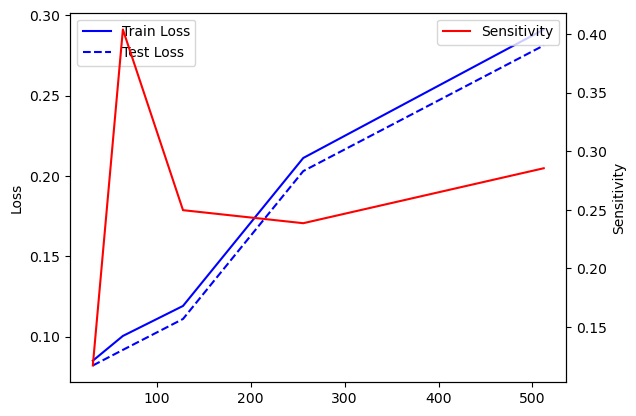

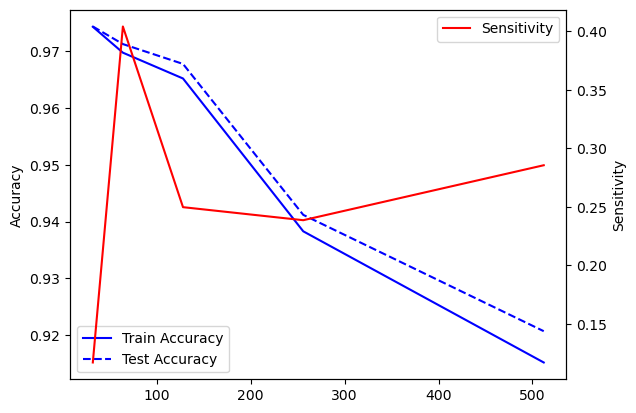

In [6]:
if __name__=='__main__':
    Epoch = 10
    batch_size = [32,64,128,256,512]
    train_loss=[]; test_loss=[]
    train_acc=[]; test_acc=[]
    senitivity=[]
    for bs in batch_size:
        print('Run for batch size = {}..'.format(bs))
        model = my_cnn().to(device)
        trainloader, testloader = loader_(bs)
        model = Train_(model,trainloader)
        
        aux = find_loss(model,trainloader)
        train_acc.append(aux[0].cpu().item())
        train_loss.append(aux[1].cpu().item())

        aux = find_loss(model,testloader)
        test_acc.append(aux[0].cpu().item())
        test_loss.append(aux[1].cpu().item())
            
        Norm = 0
        c = 0
        for p in model.parameters():
            grad = 0.0
            if p.grad is not None:
                grad = p.grad.cpu()
                fNorm = torch.linalg.norm(grad).numpy()
                Norm += fNorm
                c += 1
        senitivity.append(Norm/c)

    plt.plot(batch_size, train_loss, color='b', label='Train Loss')
    plt.plot(batch_size, test_loss, '--', color='b', label='Test Loss')
    plt.ylabel('Loss')
    plt.legend()
    plt.twinx()
    plt.plot(batch_size, senitivity, color='r', label='Sensitivity')
    plt.xlabel('Batch Size')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.show()

    plt.plot(batch_size, train_acc, color='b', label='Train Accuracy')
    plt.plot(batch_size, test_acc, '--', color='b', label='Test Accuracy')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower left')
    plt.twinx()
    plt.plot(batch_size, senitivity, color='r', label='Sensitivity')
    plt.xlabel('Batch Size')
    plt.ylabel('Sensitivity')
    plt.legend()
    plt.show()